In [15]:
import pandas as pd
import numpy as np
import theano
import lasagne
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
from lasagne.layers import InputLayer, Conv2DLayer, DropoutLayer,\
                           MaxPool2DLayer, DenseLayer, ReshapeLayer
from lasagne.objectives import categorical_crossentropy
from nolearn.lasagne import BatchIterator
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt

In [2]:
class FlipBatchIterator(BatchIterator):
    def transform(self, Xb, yb):
        """
        Flip randomly half of the images and their associated landmarks
        """
        Xb, yb = super(FlipBatchIterator, self).transform(Xb, yb)

        bs = Xb.shape[0]
        indices = np.random.choice(bs, bs//2, replace=False)
        Xb[indices] = Xb[indices, :, :, ::-1]

        if yb is not None:
            yb[indices, ::2] = yb[indices, ::2] * -1

        return Xb, yb

class AdjustVariable(object):
    """
    Used to decreases linearly the learning rate with the number of epochs,
    while we the momentum increase.
    """
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = np.float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)

In [3]:
data = pd.read_csv("images_1.csv",nrows=1000,index_col=0)
data_np = np.array(data)

# Preparando los datos

In [4]:
X  = np.array(list(map(lambda X: np.fromstring(X[0],sep=" ").reshape(128,128) ,data_np)),dtype=np.float32)

y = np.array(list(map(lambda X: np.fromstring(X[1],sep=" ").reshape(100,2) ,data_np)),dtype=np.float32)

y = y.reshape((y.shape[0],y.shape[1]*2))

In [5]:
from sklearn.preprocessing import MinMaxScaler

y = np.array(list(map(lambda x: MinMaxScaler().fit_transform(x),y)))

/usr/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it

In [7]:
X = np.array(list(map(lambda x: MinMaxScaler().fit_transform(x),X)))

In [8]:
X = X.reshape(-1, 1, 128, 128)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

In [10]:
np.shape(X_train)

(700, 1, 128, 128)

In [19]:
def create_network(npochs=1000, batch_s=128):
    layers_0 = [
                (InputLayer, {'shape': (None, 1, 128, 128)}),
                (Conv2DLayer, {'num_filters': 32, 'filter_size': (4, 4)}),
                (Conv2DLayer, {'num_filters': 32, 'filter_size': (4, 4)}),
                (MaxPool2DLayer, {'pool_size': 2}),
                (DropoutLayer, {'p': 0.1}),
                (Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3)}),
                (Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3)}),
                (MaxPool2DLayer, {'pool_size': 2}),
                (DropoutLayer, {'p': 0.2}),
                (Conv2DLayer, {'num_filters': 64, 'filter_size': (3, 3)}),
                (Conv2DLayer, {'num_filters': 64, 'filter_size': (3, 3)}),
                (MaxPool2DLayer, {'pool_size': 2}),        
                (DropoutLayer, {'p': 0.3}),
                (DenseLayer, {'num_units': 1500}),
                (DropoutLayer, {}),
                (DenseLayer, {'num_units': 1500}),
                (DenseLayer, {'num_units': 200, 'nonlinearity': None}),
        ]
    return NeuralNet(
        layers=layers_0,
        update=nesterov_momentum,
        update_learning_rate=theano.shared(np.float32(0.01)),
        update_momentum=theano.shared(np.float32(0.9)),

        regression=True,
        #batch_iterator_train=FlipBatchIterator(batch_size=batch_s),
        on_epoch_finished=[
            AdjustVariable('update_learning_rate', start=0.01, stop=0.001),
            AdjustVariable('update_momentum', start=0.9, stop=0.9999)
        ],
        max_epochs=npochs,
        verbose=1)


In [ ]:
net = create_network(10)
net.fit(X_train, y_train)

# Neural Network with 16468080 learnable parameters

## Layer information

  #  name         size
---  -----------  ----------
  0  input0       1x128x128
  1  conv2d1      32x125x125
  2  conv2d2      32x122x122
  3  maxpool2d3   32x61x61
  4  dropout4     32x61x61
  5  conv2d5      32x59x59
  6  conv2d6      32x57x57
  7  maxpool2d7   32x28x28
  8  dropout8     32x28x28
  9  conv2d9      64x26x26
 10  conv2d10     64x24x24
 11  maxpool2d11  64x12x12
 12  dropout12    64x12x12
 13  dense13      1500
 14  dropout14    1500
 15  dense15      1500
 16  dense16      200

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -------
      1     0.30332     0.29114    1.04182  524.49s
      2     0.29751     0.28695    1.03680  527.57s


In [14]:
from sklearn.metrics import mean_squared_error,  mean_absolute_error, explained_variance_score, r2_score
y_pred = net.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)) * 48)
print(explained_variance_score(y_test.ravel(), y_pred.ravel()))
#print mean_absolute_error(y_test, y_pred) * 48
print(r2_score(y_test, y_pred))

16.1233234406
-0.0238327980042
-1.11711556594
+++++++++++++++


/usr/lib/python3.6/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


In [18]:
from nolearn.lasagne import PrintLayerInfo
layer_info = PrintLayerInfo()
net.verbose = 3
net.initialize()
layer_info(net)

# Neural Network with 21397488 learnable parameters

## Layer information

name        size          total    cap.Y    cap.X    cov.Y    cov.X    filter Y    filter X    field Y    field X
----------  ----------  -------  -------  -------  -------  -------  ----------  ----------  ---------  ---------
input0      1x128x128     16384   100.00   100.00   100.00   100.00         128         128        128        128
conv2d1     32x125x125   500000   100.00   100.00     3.12     3.12           4           4          4          4
maxpool2d2  32x62x62     123008   100.00   100.00     3.12     3.12           4           4          4          4
dropout3    32x62x62     123008   100.00   100.00   100.00   100.00         128         128        128        128
conv2d4     32x60x60     115200   100.00   100.00   100.00   100.00         128         128        128        128
maxpool2d5  32x30x30      28800   100.00   100.00   100.00   100.00         128         128        128        128
dropout6    3

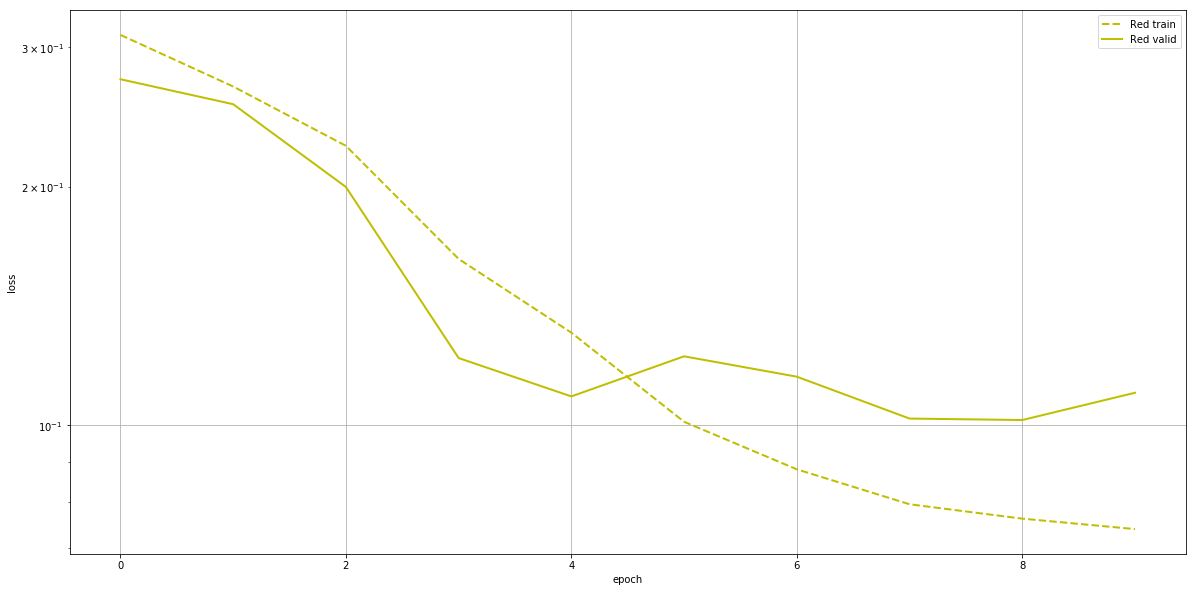

In [17]:
%matplotlib inline

plt.clf()
plt.figure(figsize=(20,10))
for net, net_name, color in zip([net], ['Red'], ['y']):
    train_loss = np.array([i["train_loss"] for i in net.train_history_])
    valid_loss = np.array([i["valid_loss"] for i in net.train_history_])
    plt.plot(train_loss[:1000], '--{}'.format(color), linewidth=2, label="{} train".format(net_name))
    plt.plot(valid_loss[:1000], '-{}'.format(color), linewidth=2, label="{} valid".format(net_name))

plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")
plt.show()